# Installation Setup

In [388]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [390]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import StockPortfolioEnv

from datetime import datetime as dt
from datetime import timedelta

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

TIME_ZONE = "America/New_York"

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [391]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Data

In [392]:
Datasets = os.path.dirname(os.getcwd()) + "\\data\\"
__depends__ = [Datasets+"RetailMarketOrder.sas7bdat", 
               Datasets+"InstitutionOrder.sas7bdat", 
               Datasets+"FutureReturn.sas7bdat"]
__dest__ = []

In [393]:
__depends__

['D:\\Google Drive - Columbia University\\AI4Finance\\Imitation Learning\\data\\RetailMarketOrder.sas7bdat',
 'D:\\Google Drive - Columbia University\\AI4Finance\\Imitation Learning\\data\\InstitutionOrder.sas7bdat',
 'D:\\Google Drive - Columbia University\\AI4Finance\\Imitation Learning\\data\\FutureReturn.sas7bdat']

## Column Details

- permno is the permanent stock identifier used in CRSP
- Retail Market Order Imbalance (moribvol) = (Shares Purchased - Shares Sold)/(Shares Purchased+Shares Sold)
    - We standardize by dividing the sum of total buy and sell retail market orders to make this variable comparable across different stocks
    - Tracking Retail Investor Activity: https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13033
- 5 Russell groups
    - Classification of stocks according to the constituent members of Russell indices
    - Large-Cap (russellgroup = 1): stocks in Russell Top 200, which consists of the largest 200 members in Russell 1000
    - Mid-Cap (russellgroup = 2): stocks in Russell Mid-Cap, which consists of the smallest 800 members in Russell 1000
    - Small-Cap (russellgroup = 3): the largest 1000 members in Russell 2000
    - Micro-Cap (russellgroup = 4): stocks in Russell Micro-Cap, which consists of the smallest 1000 members in Russell 2000 plus the largest 1000 stocks outside Russell 2000
    - Nano-Cap (russellgroup = 5): all remaining stocks
- 11 sectors
    - The Global Industry Classification Standard (GICS)
    - I name a sector using the corresponding ticker of the SPDR sector ETF (see, https://www.sectorspdr.com/sectorspdr/)

In [394]:
retail = pd.read_sas(__depends__[0], encoding = 'latin-1')
retail.columns = retail.columns.str.lower()
retail[['permno','russellgroup']] = retail[['permno','russellgroup']].astype(int)
retail.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,moribvol
14431820,93436,TSLA,TESLA INC,2021-12-27,1,XLY,"1,093.940","1,098,605.595",0.001
14431821,93436,TSLA,TESLA INC,2021-12-28,1,XLY,"1,088.470","1,093,112.295",-0.021
14431822,93436,TSLA,TESLA INC,2021-12-29,1,XLY,"1,086.190","1,090,822.542",-0.033
14431823,93436,TSLA,TESLA INC,2021-12-30,1,XLY,"1,070.340","1,074,904.966",-0.007
14431824,93436,TSLA,TESLA INC,2021-12-31,1,XLY,"1,056.780","1,092,190.615",-0.087


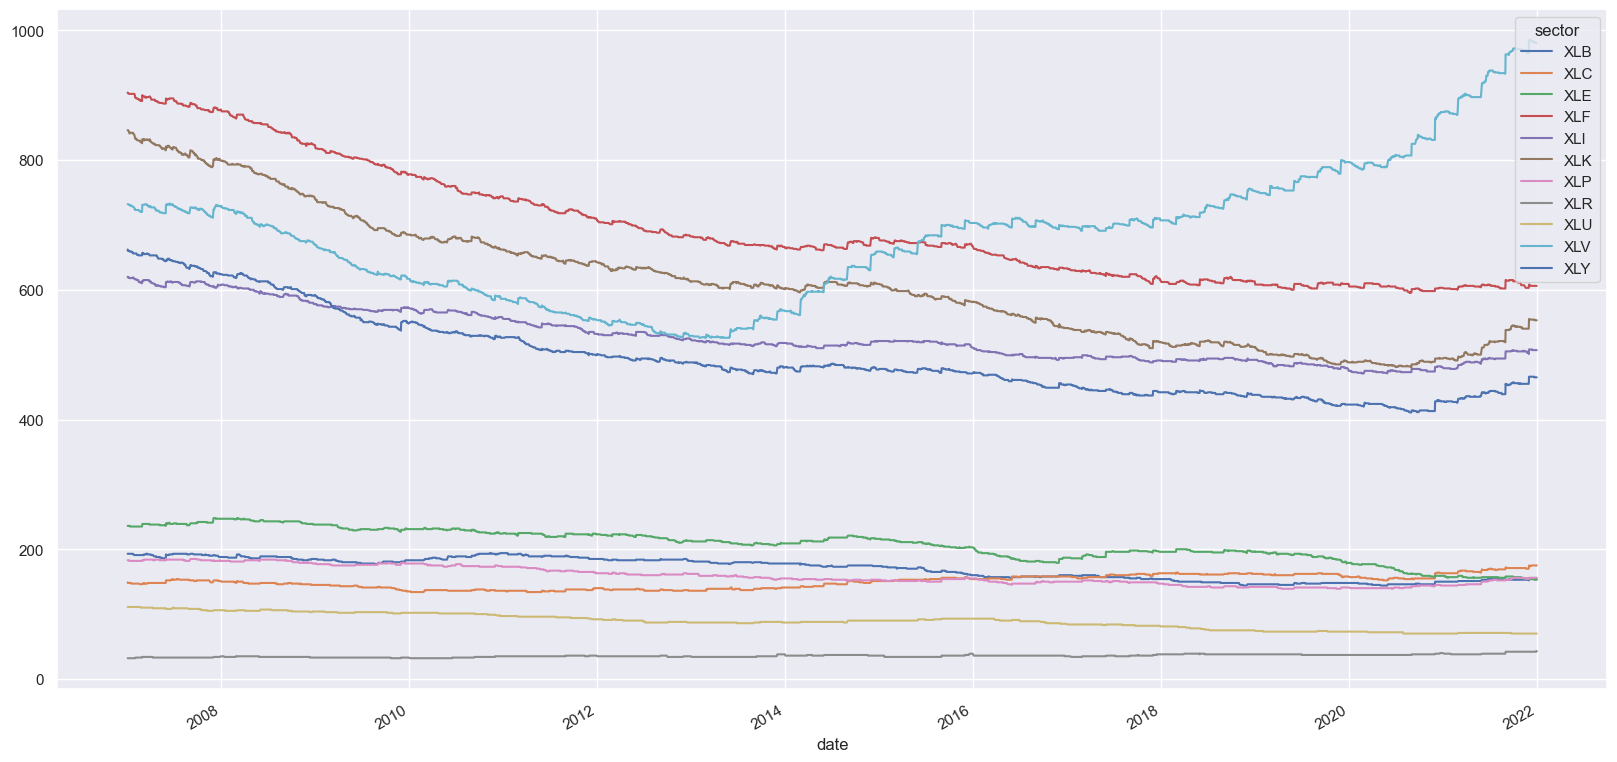

In [395]:
retail.groupby(['date','sector'])['permno'].count().unstack().plot();

In [396]:
institution = pd.read_sas(__depends__[1], encoding = 'latin-1')
institution.columns = institution.columns.str.lower()
institution[['permno','russellgroup']] = institution[['permno','russellgroup']].astype(int)
institution.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,iibvol
10772976,93436,TSLA,TESLA MOTORS INC,2011-03-25,2,XLY,22.750,"2,168.871",0.000
10772977,93436,TSLA,TESLA MOTORS INC,2011-03-28,2,XLY,23.250,"2,216.539",1.000
10772978,93436,TSLA,TESLA MOTORS INC,2011-03-29,2,XLY,23.920,"2,280.413",0.000
10772979,93436,TSLA,TESLA MOTORS INC,2011-03-30,2,XLY,23.710,"2,260.393",0.000
10772980,93436,TSLA,TESLA MOTORS INC,2011-03-31,2,XLY,27.750,"2,651.651",-1.000


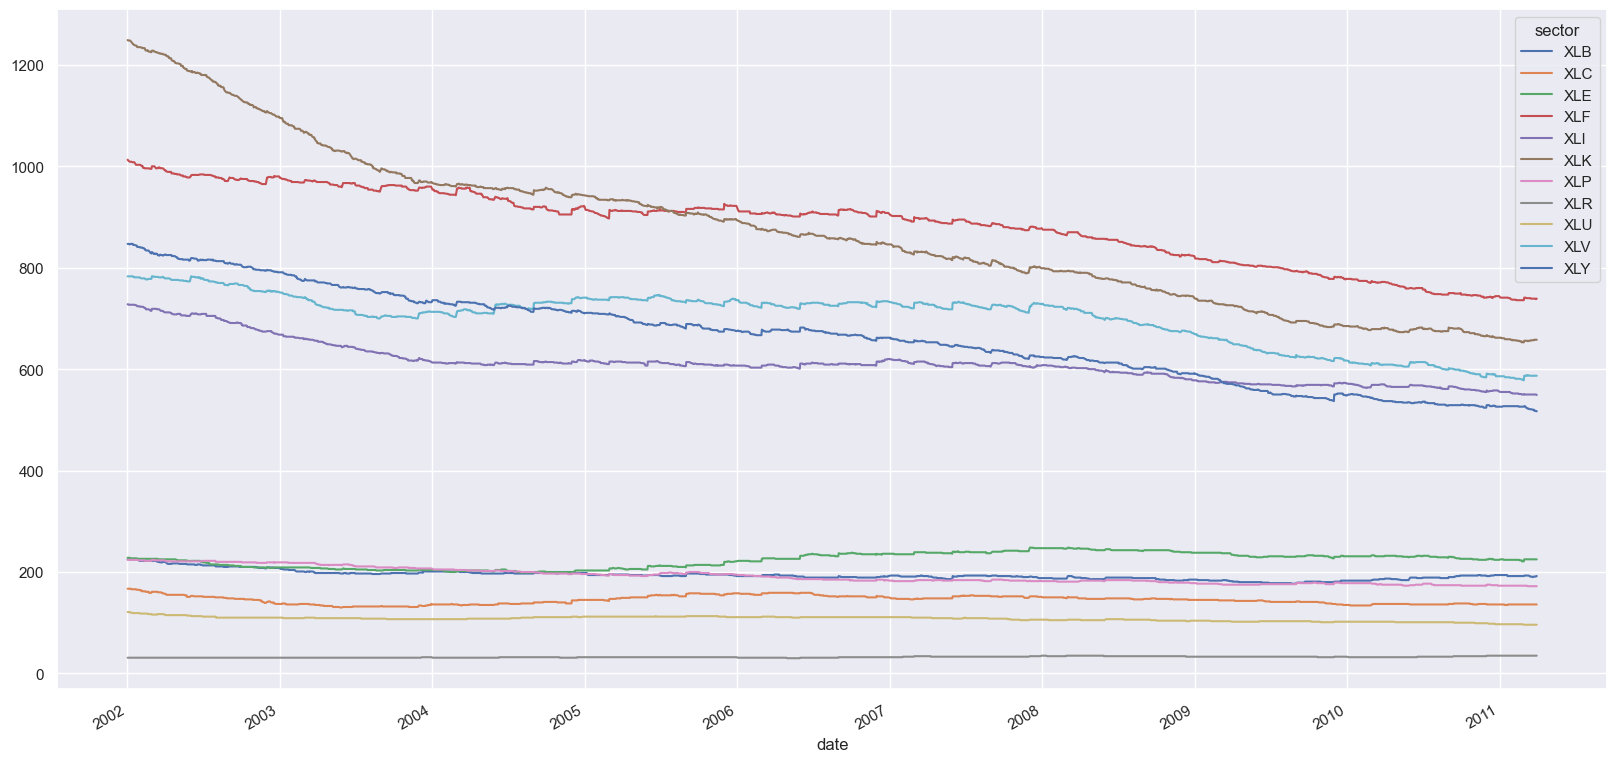

In [397]:
institution.groupby(['date','sector'])['permno'].count().unstack().plot();

In [398]:
ret = pd.read_sas(__depends__[2], encoding = 'latin-1')
ret.columns = ret.columns.str.lower()
ret['permno'] = ret['permno'].astype(int)
ret.tail()

,permno,date,ret_1,ret_5,ret_10,ret_20
21466675,93436,2021-12-27,-0.005,0.097,-0.033,-0.160
21466676,93436,2021-12-28,-0.002,0.056,-0.022,-0.139
21466677,93436,2021-12-29,-0.015,0.002,0.018,-0.237
21466678,93436,2021-12-30,-0.013,-0.005,-0.036,-0.209
21466679,93436,2021-12-31,0.135,-0.028,-0.007,-0.114


- ret_i, i = 1,5,10,20, is the return over next day, 5 days, 10 days, 20 days
    - I already moved the return backward for one trading day to avoid potentisl forward-looking bias. For example, -0.003 ret_1 of stock 93436 at 2022-06-24 is the return earned by this stock at 2022-06-27

## Missing Data

In [399]:
retail.isna().sum()
ret.isna().sum()

permno            0
ticker            0
companyname       0
date              0
russellgroup      0
sector            0
price           768
marketcap       768
moribvol          0
dtype: int64

permno       0
date         0
ret_1     7834
ret_5        1
ret_10       1
ret_20       1
dtype: int64

# Statistical Tests
Mean annual returns and their t-statistics

## Group by Cap size with retailer investment

In [400]:
# Cap size with retailers
ptflist = ['Low','2','3','4','5','6','7','8','9','High','H-L']
stock_grp = ['Large-Cap','Mid-Cap','Small-Cap','Micro-Cap','Nano-Cap']
results = pd.DataFrame([], columns = stock_grp, 
                       index = ['Low','','2','','3','','4','','5','','6','','7','','8','','9','','High','','H-L',''])
results.index.name = 'Retail Market Order Imbalance'

fut_ret = 'ret_5'
for i in np.arange(5):
    stock_grp[i]
    df_ = pd.merge(retail[retail['russellgroup'] == (i+1)][['permno','date','moribvol']], 
                   ret, on = ['permno','date'], how = 'inner')
    breakpoints = df_.groupby('date')['moribvol'].describe(percentiles = [.1,.2,.3,.4,.5,.6,.7,.8,.9])
    df_ = pd.merge(df_, breakpoints, on = 'date', how = 'left')
     
    def group(row, signal = 'moribvol'):
        if row[signal] < row['10%']:
            value = 'Low'
        elif row[signal] < row['20%']:
            value = '2'
        elif row[signal] < row['30%']:
            value = '3'
        elif row[signal] < row['40%']:
            value = '4'
        elif row[signal] < row['50%']:
            value = '5'
        elif row[signal] < row['60%']:
            value = '6'
        elif row[signal] < row['70%']:
            value = '7'
        elif row[signal] < row['80%']:
            value = '8'
        elif row[signal] < row['90%']:
            value = '9'
        elif row[signal] >= row['90%']:
            value = 'High'
        else:
            value = np.nan
        return value
        
    df_['rank'] = df_.apply(group, axis = 1) 
    ptf = df_.groupby(['date','rank'])[fut_ret].mean().unstack().dropna()
    ptf['H-L'] = ptf['High']-ptf['Low']
    ptf['const'] = 1
    for j in np.arange(11):
        res = sm.OLS(ptf[ptflist[j]], ptf['const'], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
        results.iloc[2*j,i] = 252*res.params[0]
        results.iloc[2*j+1,i] = res.tvalues[0]
    
results

'Large-Cap'

'Mid-Cap'

'Small-Cap'

'Micro-Cap'

'Nano-Cap'

,Large-Cap,Mid-Cap,Small-Cap,Micro-Cap,Nano-Cap
Retail Market Order Imbalance,,,,,
Low,0.595,0.585,1.051,0.585,0.674
,4.151,3.530,6.204,3.639,2.684
2,0.620,0.601,1.105,0.508,0.569
,4.189,3.518,6.082,2.470,1.584
3,0.553,0.691,1.152,0.486,0.505
,3.782,3.916,6.143,2.141,1.220
4,0.607,0.679,1.236,0.467,-0.048
,4.003,3.737,6.343,1.957,-0.110
5,0.581,0.670,1.331,0.517,-1.282


## Group by Sector with Retailer Investment

In [401]:
# Sector 
ptflist = ['Low','2','3','4','5','6','7','8','9','High','H-L']
stock_grp = ['XLU','XLF','XLB','XLP','XLY','XLK','XLV','XLI','XLE','XLC','XLR']
results = pd.DataFrame([], columns = stock_grp, 
                       index = ['Low','','2','','3','','4','','5','','6','','7','','8','','9','','High','','H-L',''])
results.index.name = 'Retail Market Order Imbalance'

fut_ret = 'ret_5'
for i in np.arange(11):
    stock_grp[i]
    df_ = pd.merge(retail[retail['sector'] == stock_grp[i]][['permno','date','moribvol']], 
                   ret, on = ['permno','date'], how = 'inner')
    breakpoints = df_.groupby('date')['moribvol'].describe(percentiles = [.1,.2,.3,.4,.5,.6,.7,.8,.9])
    df_ = pd.merge(df_, breakpoints, on = 'date', how = 'left')
     
    def group(row, signal = 'moribvol'):
        if row[signal] < row['10%']:
            value = 'Low'
        elif row[signal] < row['20%']:
            value = '2'
        elif row[signal] < row['30%']:
            value = '3'
        elif row[signal] < row['40%']:
            value = '4'
        elif row[signal] < row['50%']:
            value = '5'
        elif row[signal] < row['60%']:
            value = '6'
        elif row[signal] < row['70%']:
            value = '7'
        elif row[signal] < row['80%']:
            value = '8'
        elif row[signal] < row['90%']:
            value = '9'
        elif row[signal] >= row['90%']:
            value = 'High'
        else:
            value = np.nan
        return value
        
    df_['rank'] = df_.apply(group, axis = 1) 
    ptf = df_.groupby(['date','rank'])[fut_ret].mean().unstack().dropna()
    ptf['H-L'] = ptf['High']-ptf['Low']
    ptf['const'] = 1
    for j in np.arange(11):
        res = sm.OLS(ptf[ptflist[j]], ptf['const'], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
        results.iloc[2*j,i] = 252*res.params[0]
        results.iloc[2*j+1,i] = res.tvalues[0]
    
results

'XLU'

'XLF'

'XLB'

'XLP'

'XLY'

'XLK'

'XLV'

'XLI'

'XLE'

'XLC'

'XLR'

,XLU,XLF,XLB,XLP,XLY,XLK,XLV,XLI,XLE,XLC,XLR
Retail Market Order Imbalance,,,,,,,,,,,
Low,0.467,0.694,0.326,0.323,0.501,0.603,0.586,0.567,-0.225,0.397,0.747
,3.252,3.701,1.558,2.175,2.592,3.633,3.093,3.211,-0.765,1.354,1.966
2,0.599,0.620,0.467,0.612,0.581,0.716,0.647,0.651,0.045,0.688,0.472
,4.243,2.564,2.067,3.703,2.551,3.760,3.046,3.219,0.133,2.084,1.114
3,0.460,0.646,0.622,0.652,0.766,0.687,0.623,0.608,0.222,0.490,0.400
,3.352,2.514,2.682,4.388,3.288,3.499,2.921,2.921,0.616,1.635,0.893
4,0.535,0.630,0.633,0.698,0.734,0.837,0.695,0.714,0.207,0.679,0.753
,3.741,2.449,2.629,4.667,3.122,4.125,3.273,3.395,0.598,2.133,1.360
5,0.428,0.645,0.763,0.674,0.693,0.829,0.630,0.676,0.169,0.506,0.236


## Group by Cap Size with Institution Investment

In [402]:
# Cap size with institutions
ptflist = ['Low','2','3','4','5','6','7','8','9','High','H-L']
stock_grp = ['Large-Cap','Mid-Cap','Small-Cap']
results = pd.DataFrame([], columns = stock_grp, 
                       index = ['Low','','2','','3','','4','','5','','6','','7','','8','','9','','High','','H-L',''])
results.index.name = 'Institution Order Imbalance'

fut_ret = 'ret_1'
for i in np.arange(3):
    stock_grp[i]
    df_ = pd.merge(institution[institution['russellgroup'] == (i+1)][['permno','date','iibvol']], 
                   ret, on = ['permno','date'], how = 'inner')
    breakpoints = df_.groupby('date')['iibvol'].describe(percentiles = [.1,.2,.3,.4,.5,.6,.7,.8,.9])
    df_ = pd.merge(df_, breakpoints, on = 'date', how = 'left')
     
    def group(row, signal = 'iibvol'):
        if row[signal] < row['10%']:
            value = 'Low'
        elif row[signal] < row['20%']:
            value = '2'
        elif row[signal] < row['30%']:
            value = '3'
        elif row[signal] < row['40%']:
            value = '4'
        elif row[signal] < row['50%']:
            value = '5'
        elif row[signal] < row['60%']:
            value = '6'
        elif row[signal] < row['70%']:
            value = '7'
        elif row[signal] < row['80%']:
            value = '8'
        elif row[signal] < row['90%']:
            value = '9'
        elif row[signal] >= row['90%']:
            value = 'High'
        else:
            value = np.nan
        return value
        
    df_['rank'] = df_.apply(group, axis = 1) 
    ptf = df_.groupby(['date','rank'])[fut_ret].mean().unstack().dropna()
    ptf['H-L'] = ptf['High']-ptf['Low']
    ptf['const'] = 1
    for j in np.arange(11):
        res = sm.OLS(ptf[ptflist[j]], ptf['const'], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
        results.iloc[2*j,i] = 252*res.params[0]
        results.iloc[2*j+1,i] = res.tvalues[0]
    
results

'Large-Cap'

'Mid-Cap'

'Small-Cap'

,Large-Cap,Mid-Cap,Small-Cap
Institution Order Imbalance,,,
Low,0.042,0.060,-0.413
,0.434,0.178,-0.280
2,0.009,0.032,-0.200
,0.098,0.099,-0.141
3,0.040,-0.021,-0.806
,0.457,-0.067,-0.481
4,0.084,0.103,-0.229
,0.979,0.329,-0.185
5,0.107,0.160,-0.381


# More Data Explorations

In [403]:
# All data points - merged retail imblance trades and returns rates
retail_ret = pd.merge(retail[['ticker','permno','date','moribvol', "russellgroup", "sector", "price"]], 
                      ret, 
                      on = ['permno','date'], 
                      how = 'inner')

START_DATE = min(retail_ret.date).strftime('%Y-%m-%d')
END_DATE = max(retail_ret.date).strftime('%Y-%m-%d')

retail_ret = retail_ret.rename(columns={'ticker': 'tic'})
retail_ret

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20
0,EWST,10001,2007-01-03,-1.000,5,XLU,11.100,0.023,-0.000,0.035,0.027
1,EWST,10001,2007-01-04,0.000,5,XLU,11.360,-0.010,0.008,-0.018,-0.014
2,EWST,10001,2007-01-05,0.000,5,XLU,11.250,0.008,0.010,-0.004,0.019
3,EWST,10001,2007-01-08,0.000,5,XLU,11.345,-0.009,-0.002,0.010,0.004
4,EWST,10001,2007-01-09,1.000,5,XLU,11.240,-0.012,0.019,0.019,0.014
...,...,...,...,...,...,...,...,...,...,...,...
14431820,TSLA,93436,2021-12-27,0.001,1,XLY,"1,093.940",-0.005,0.097,-0.033,-0.160
14431821,TSLA,93436,2021-12-28,-0.021,1,XLY,"1,088.470",-0.002,0.056,-0.022,-0.139
14431822,TSLA,93436,2021-12-29,-0.033,1,XLY,"1,086.190",-0.015,0.002,0.018,-0.237
14431823,TSLA,93436,2021-12-30,-0.007,1,XLY,"1,070.340",-0.013,-0.005,-0.036,-0.209


In [404]:
print(retail_ret.dtypes)

tic                     object
permno                   int32
date            datetime64[ns]
moribvol               float64
russellgroup             int32
sector                  object
price                  float64
ret_1                  float64
ret_5                  float64
ret_10                 float64
ret_20                 float64
dtype: object


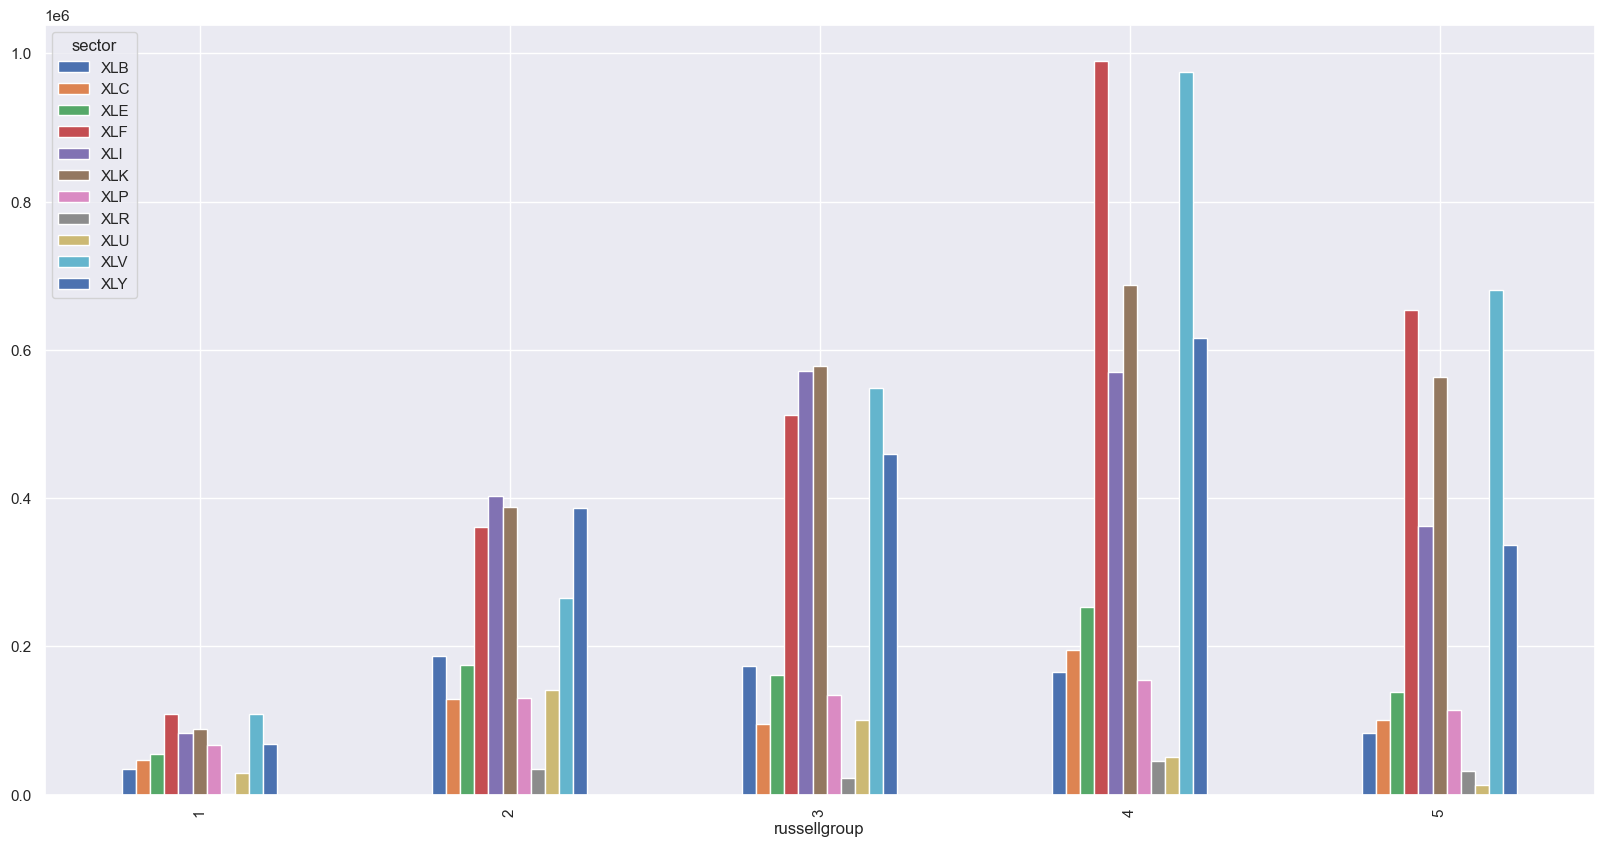

In [405]:
retail_ret.groupby(['russellgroup','sector'])['permno'].count().unstack().plot.bar();

## Correlation between Return Rates and Retailers' Net Trades

In [406]:
# Correlation anaysis between imbalance trades and return rates in the next day
fut_ret = 'ret_1'

# Company ticker, Russell group, and sector may be changed over time...
grouped = retail_ret.groupby(['permno', 'tic', "russellgroup", "sector"])
df_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna().reset_index(name='corr')

### Panel Plots of Correlation Values

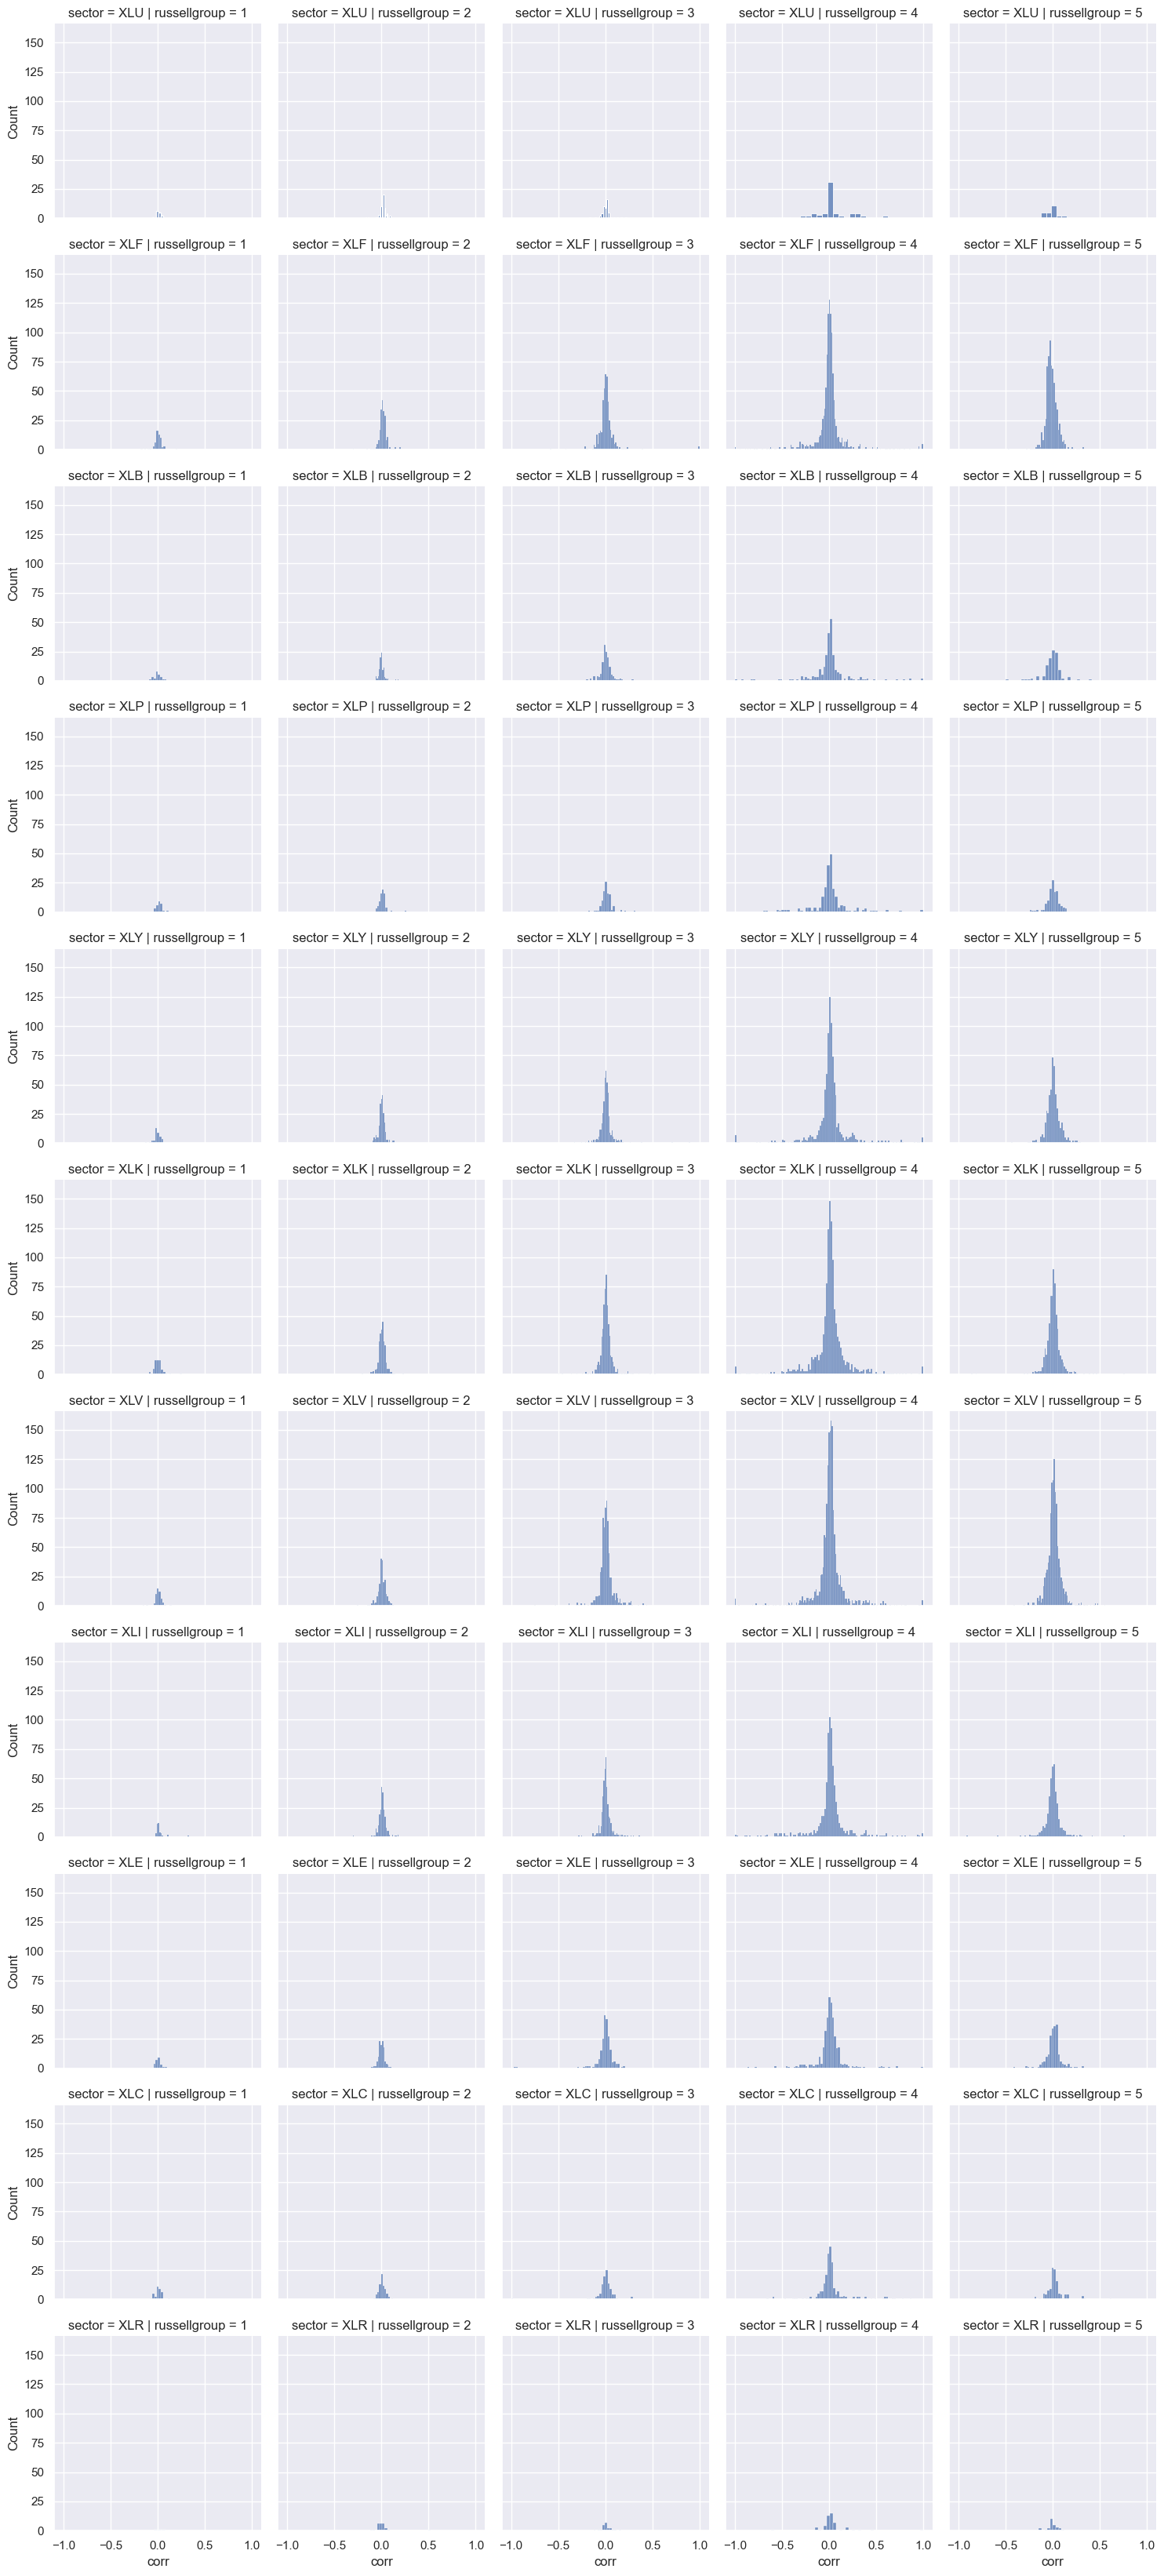

In [407]:
# A panel of plots of correlation values
g = sns.FacetGrid(df_correlation, col='russellgroup', row='sector')
g.map(sns.histplot, 'corr', kde=False)
g.fig.tight_layout()
g.fig.show()

### Correlation Distribution over Sectors

sector
XLB    AxesSubplot(0.125,0.11;0.775x0.77)
XLC    AxesSubplot(0.125,0.11;0.775x0.77)
XLE    AxesSubplot(0.125,0.11;0.775x0.77)
XLF    AxesSubplot(0.125,0.11;0.775x0.77)
XLI    AxesSubplot(0.125,0.11;0.775x0.77)
XLK    AxesSubplot(0.125,0.11;0.775x0.77)
XLP    AxesSubplot(0.125,0.11;0.775x0.77)
XLR    AxesSubplot(0.125,0.11;0.775x0.77)
XLU    AxesSubplot(0.125,0.11;0.775x0.77)
XLV    AxesSubplot(0.125,0.11;0.775x0.77)
XLY    AxesSubplot(0.125,0.11;0.775x0.77)
Name: corr, dtype: object

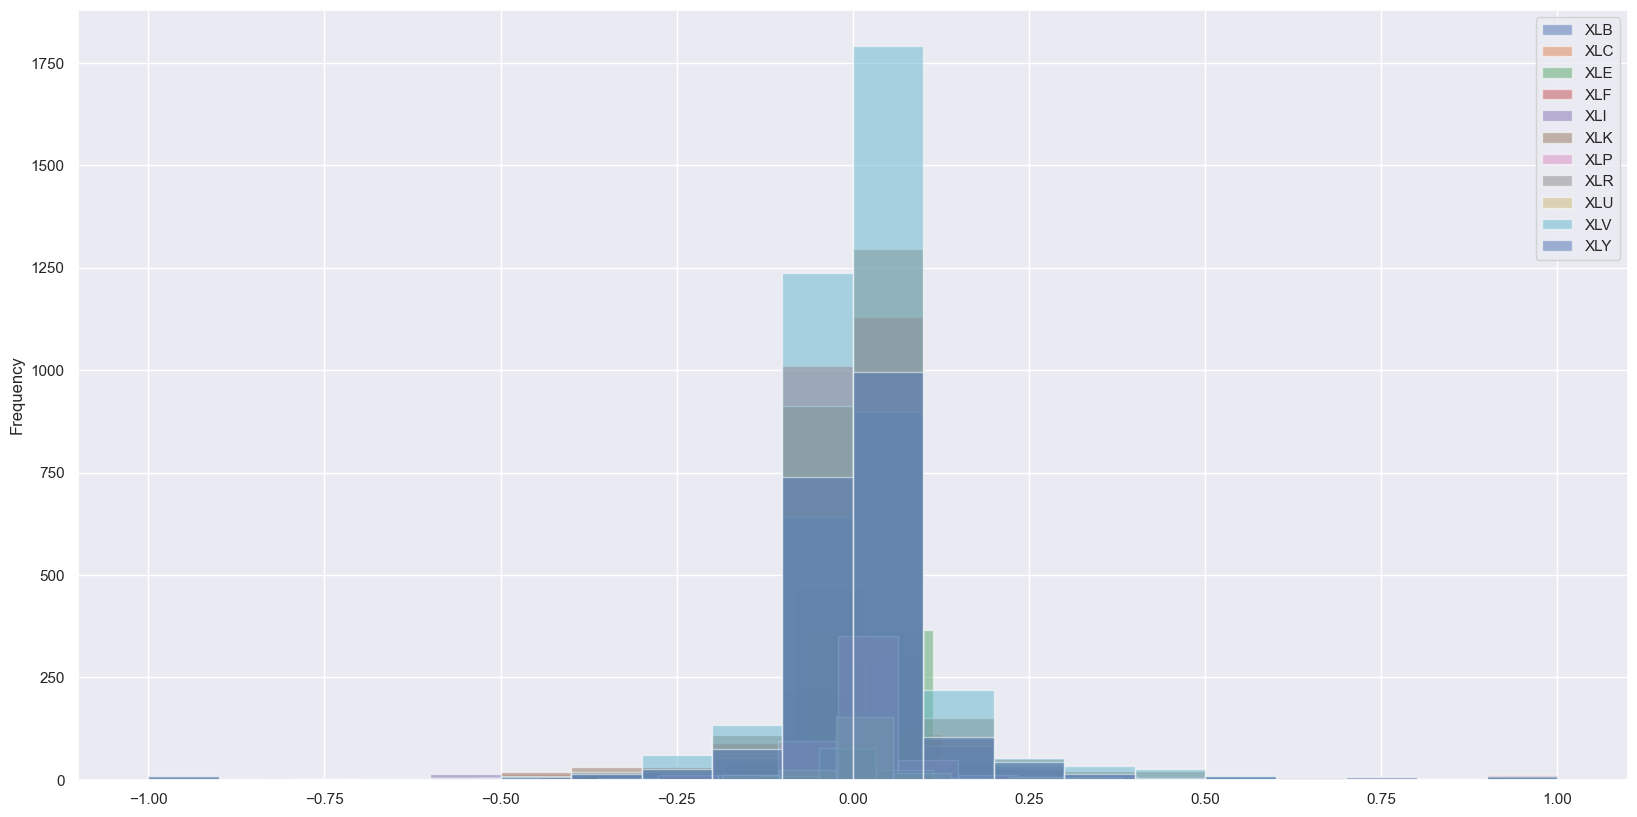

In [408]:
# Plot the distribution of correlation values for each sectors
grouped = df_correlation.groupby(['sector'])
grouped['corr'].plot.hist(alpha=0.5, bins=20)

plt.legend()
plt.show()

### Top Correlated Stocks over Sectors and Cap Size

In [409]:
# Max correlated stocks in different cap sizes and sectors
def get_max_row(group):
    return group[group['corr'] == group['corr'].max()].iloc[0, :]

df_correlation.groupby(['russellgroup','sector']).apply(get_max_row)

permno   tic  russellgroup sector  corr
russellgroup sector                                         
1            XLB      16851  DWDP             1    XLB 0.093
             XLC      18421   FOX             1    XLC 0.132
             XLE      13141   WPX             1    XLE 0.101
             XLF      59459   STA             1    XLF 0.209
             XLI      12623   HII             1    XLI 0.329
             XLK      40125   DXC             1    XLK 0.252
             XLP      15472   WWY             1    XLP 0.115
             XLR      91388     H             1    XLR 0.083
             XLU      27959   DUK             1    XLU 0.055
             XLV      92988   CFN             1    XLV 0.144
             XLY      91392   WYN             1    XLY 0.059
2            XLB      24643  ARNC             2    XLB 0.178
             XLC      60599  LUMN             2    XLC 0.125
             XLE      60695   PPP             2    XLE 0.103
             XLF      14685  FNFV             2    XLF 0.205
             XLI      92729   JBT             2    XLI 0.182
             XLK      84624  MVSN             2    XLK 0.237
             XLP      38295   HRG             2    XLP 0.265
             XLR      14252  GLPI             2    XLR 0.520
             XLU      14831  TERP             2    XLU 0.092
             XLV      16543  VREX             2    XLV 0.128
             XLY      18578   KTB             2    XLY 0.136
3            XLB      89874  WPSC             3    XLB 0.300
             XLC      86743  CTCI             3    XLC 0.294
             XLE      92395   NES             3    XLE 0.211
             XLF      89109  MFNC             3    XLF 1.000
             XLI      91299   GFN             3    XLI 0.366
             XLK      87482  DMRC             3    XLK 0.533
             XLP      11790  ALCO             3    XLP 0.322
             XLR      93433  MOTR             3    XLR 0.166
             XLU      91840    RZ             3    XLU 0.231
             XLV      13761  STML             3    XLV 0.448
             XLY      87379  CLCT             3    XLY 0.900
4            XLB      91893  COIN             4    XLB 1.000
             XLC      14984  ZAYO             4    XLC 0.878
             XLE      13695  MEIL             4    XLE 1.000
             XLF      22032  CBSS             4    XLF 1.000
             XLI      92924   DGI             4    XLI 1.000
             XLK      84168    IM             4    XLK 1.000
             XLP      90159   ASB             4    XLP 1.000
             XLR      22426  DOUG             4    XLR 1.000
             XLU      90245   EGR             4    XLU 0.627
             XLV      80579  TRPS             4    XLV 1.000
             XLY      11908  EDCI             4    XLY 1.000
5            XLB      91946   SHJ             5    XLB 0.420
             XLC      17323  LIVX             5    XLC 0.628
             XLE      79393  EWEB             5    XLE 0.334
             XLF      90171   SBK             5    XLF 0.335
             XLI      76586  PICO             5    XLI 0.769
             XLK      15410  APPF             5    XLK 0.765
             XLP      16310  SISI             5    XLP 0.154
             XLR      20147   AEI             5    XLR 0.123
             XLU      84345  USEY             5    XLU 0.148
             XLV      22229  PYXS             5    XLV 0.561
             XLY      12349  BODY             5    XLY 0.302

# Stock Selection

## Tech Giants
> Picked 11 Large Cap Tech (XLK) firms whose retail investor trades are significantly correlatede with return rates in 5 days. Stocks are ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]

In [410]:
tech_largeCap = retail[(retail["sector"] == 'XLK') & (retail["russellgroup"] == 1)]
tech_largeCap_ret = pd.merge(tech_largeCap[['ticker','permno','date','moribvol', "price", "russellgroup"]], 
                             ret, 
                             on = ['permno','date'], 
                             how = 'inner')

tech_largeCap_ret

,ticker,permno,date,moribvol,price,russellgroup,ret_1,ret_5,ret_10,ret_20
0,SUNW,10078,2007-01-03,-0.161,5.540,1,0.027,0.083,0.045,0.182
1,SUNW,10078,2007-01-04,0.236,5.690,1,-0.016,0.079,0.014,0.165
2,SUNW,10078,2007-01-05,0.254,5.600,1,0.009,0.082,0.027,0.186
3,SUNW,10078,2007-01-08,-0.294,5.650,1,0.014,0.073,0.002,0.156
4,SUNW,10078,2007-01-09,0.762,5.730,1,0.047,0.045,0.073,0.150
...,...,...,...,...,...,...,...,...,...,...
88785,AOL,93091,2010-05-24,-0.040,21.200,1,-0.025,-0.033,-0.041,0.082
88786,AOL,93091,2010-05-25,0.038,20.680,1,0.002,0.015,-0.023,0.095
88787,AOL,93091,2010-05-26,-0.280,20.720,1,0.021,0.014,0.019,0.049
88788,AOL,93091,2010-05-27,0.159,21.160,1,-0.025,0.006,-0.008,0.038


In [411]:
tech_largeCap_ret['ticker'].unique()

array(['SUNW', 'JAVA', 'ORCL', 'MSFT', 'EMC', 'FISV', 'DELL', 'MMI',
       'IBM', 'NOW', 'WDAY', 'AAPL', 'AMAT', 'CDK', 'PYPL', 'TXN', 'HPE',
       'SQ', 'VSM', 'ZM', 'GLW', 'MOT', 'MSI', 'HPQ', 'DXC', 'ADP',
       'LRCX', 'MU', 'INTC', 'ADI', 'AMD', 'ADBE', 'SYMC', 'CSCO', 'QCOM',
       'FDC', 'INTU', 'NTAP', 'ADSK', 'BRCM', 'CTSH', 'NVDA', 'JNPR',
       'GPN', 'FIS', 'CRM', 'MA', 'WU', 'FSLR', 'VMW', 'V', 'AVGO', 'AOL'],
      dtype=object)

In [412]:
fut_ret = 'ret_5'
grouped = tech_largeCap_ret.groupby('permno')

tech_largeCap_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna()
tech_largeCap_correlation = tech_largeCap_correlation.sort_values(ascending=False).reset_index()
tech_largeCap_correlation = tech_largeCap_correlation.rename(columns={tech_largeCap_correlation.columns[-1]: 'corr'})

tech_largeCap_correlation = tech_largeCap_correlation.merge(tech_largeCap_ret[['ticker', 'permno', "russellgroup"]], on='permno')
tech_largeCap_correlation = tech_largeCap_correlation.drop_duplicates()
tech_largeCap_correlation

,permno,corr,ticker,russellgroup
0,14926,0.256,CDK,1
124,40125,0.105,DXC,1
165,18484,0.082,ZM,1
567,77546,0.073,FDC,1
735,77178,0.055,QCOM,1
4512,85631,0.052,ADSK,1
5145,91611,0.051,FSLR,1
5648,10078,0.045,SUNW,1
5811,10078,0.045,JAVA,1
6003,10107,0.044,MSFT,1


## Comprehensive Selection

> Pick S_i that maximize corr(ret_si - ret_SPY, moribvol_si)

In [413]:
fut_ret = 'ret_1'

# add one day to the `max_date`
DAY_AFTER_END_DATE = (max(retail_ret.date) + timedelta(days=1)).strftime('%Y-%m-%d')

# S&P 500
yf_spy = YahooDownloader(start_date = START_DATE, 
                         end_date = DAY_AFTER_END_DATE, 
                         ticker_list = ["SPY"]).fetch_data()

# the next day return rates
yf_spy[fut_ret] = yf_spy['close'].pct_change()
yf_spy[fut_ret] = yf_spy[fut_ret].shift(-1)
yf_spy = yf_spy.fillna(0)
yf_spy = yf_spy.replace(np.inf,0)
yf_spy

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3777, 8)


,date,open,high,low,close,volume,tic,day,ret_1
0,2007-01-03,142.250,142.860,140.570,103.007,94807600,SPY,2,0.002
1,2007-01-04,141.230,142.050,140.610,103.226,69620600,SPY,3,-0.008
2,2007-01-05,141.330,141.400,140.380,102.402,76645300,SPY,4,0.005
3,2007-01-08,140.820,141.410,140.250,102.876,71655000,SPY,0,-0.001
4,2007-01-09,141.310,141.600,140.400,102.788,75680100,SPY,1,0.003
...,...,...,...,...,...,...,...,...,...
3772,2021-12-27,472.060,477.310,472.010,467.855,56808600,SPY,0,-0.001
3773,2021-12-28,477.720,478.810,476.060,467.473,47274600,SPY,1,0.001
3774,2021-12-29,476.980,478.560,475.920,468.071,54503000,SPY,2,-0.003
3775,2021-12-30,477.930,479.000,475.670,466.777,55329000,SPY,3,-0.003


In [414]:
SELECT_RUSSELL_GROUPS = {1, 2, 3}

# create a list of permnos that have data on both 2007-01-03 and 2021-12-31
time_valid_permnos = retail_ret.loc[retail_ret['date'].isin([START_DATE, END_DATE])] \
                               .groupby('permno') \
                               .filter(lambda x: len(x) == 2) \
                               .permno \
                               .unique()

# create a list of permnos that have never changed their ticker
tic_valid_permnos = retail_ret.groupby(['permno']).filter(lambda x: x['tic'].nunique() == 1).permno.unique()

# create a list of permnos with relatively large cap sizes
russell_valid_permnos = retail_ret.groupby(['permno']).filter(lambda x: set(x['russellgroup'].unique())
                                                              .issubset(SELECT_RUSSELL_GROUPS)).permno.unique()

# filter the retail_ret dataset 
filtered_df = retail_ret.loc[retail_ret['permno'].isin(time_valid_permnos) & 
                             retail_ret['permno'].isin(tic_valid_permnos) &
                             retail_ret['permno'].isin(russell_valid_permnos)]

# substract baseline (SPY)
filtered_df['ret_1_diff'] = filtered_df.groupby('permno')['ret_1'].transform(lambda x: x - yf_spy['ret_1'].values)

df_correlation = filtered_df.groupby(['permno']).apply(lambda x: x['moribvol'].corr(x['ret_1_diff'])).dropna().reset_index(name='corr')
df_correlation = df_correlation.merge(retail_ret[['tic', 'permno', 'sector']], on='permno').drop_duplicates()

df_correlation

,permno,corr,tic,sector
0,10032,0.030,PLXS,XLK
3777,10104,0.023,ORCL,XLK
7554,10107,0.021,MSFT,XLK
11331,10138,0.005,TROW,XLF
15108,10145,0.008,HON,XLI
...,...,...,...,...
2228430,91579,-0.015,KBR,XLI
2232207,91594,0.002,SPR,XLI
2235984,91611,0.006,FSLR,XLK
2239761,91683,0.022,SBH,XLY


<AxesSubplot: ylabel='Frequency'>

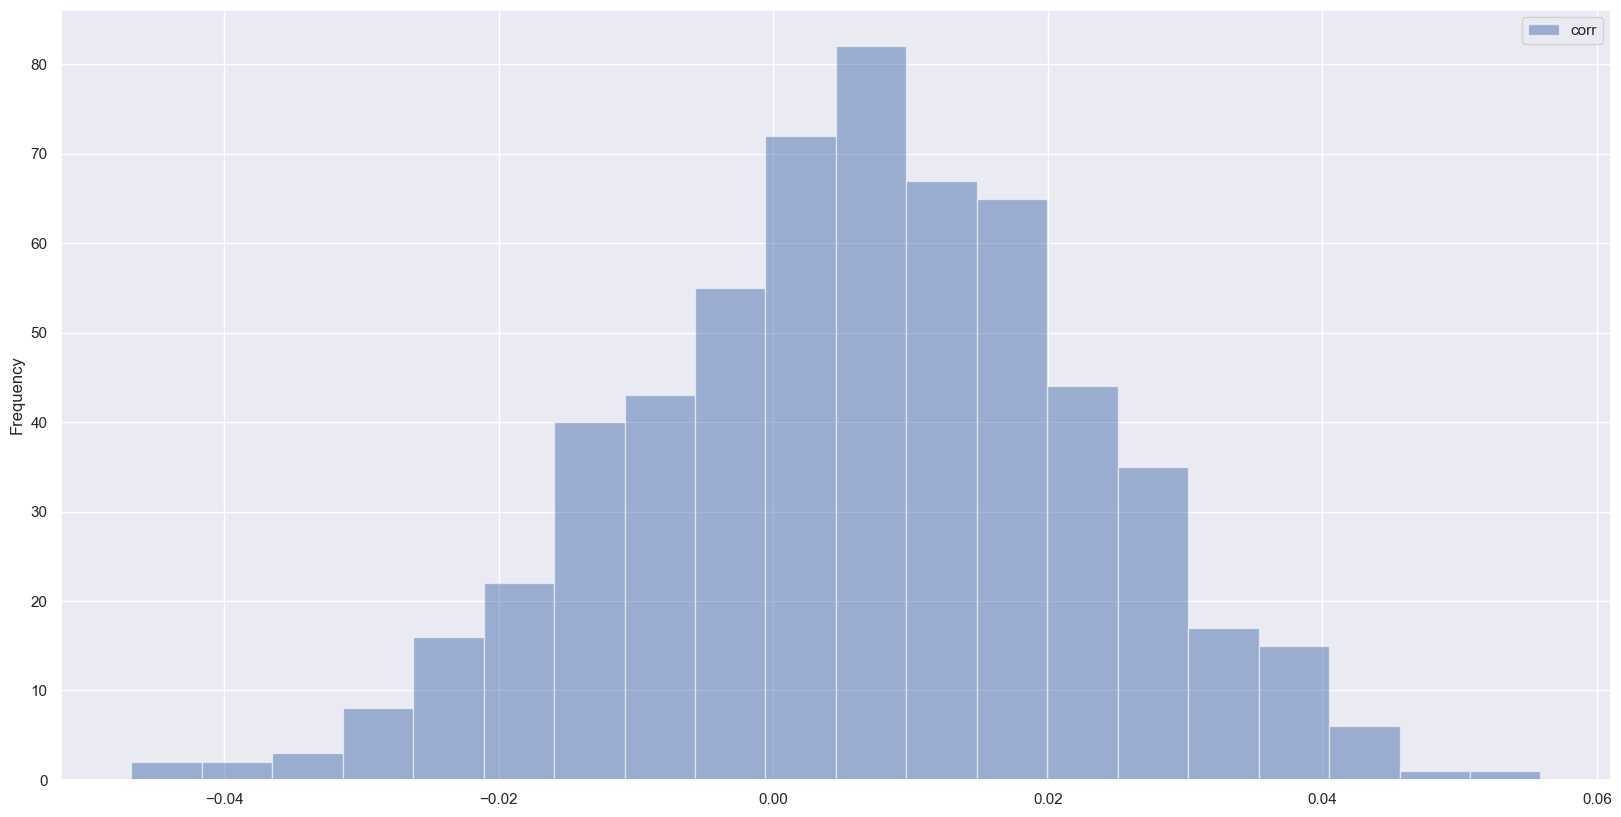

In [415]:
# Plot the distribution of correlation values
df_correlation['corr'].plot.hist(alpha=0.5, bins=20)

plt.legend()
plt.show()

sector
XLB    AxesSubplot(0.125,0.11;0.775x0.77)
XLC    AxesSubplot(0.125,0.11;0.775x0.77)
XLE    AxesSubplot(0.125,0.11;0.775x0.77)
XLF    AxesSubplot(0.125,0.11;0.775x0.77)
XLI    AxesSubplot(0.125,0.11;0.775x0.77)
XLK    AxesSubplot(0.125,0.11;0.775x0.77)
XLP    AxesSubplot(0.125,0.11;0.775x0.77)
XLR    AxesSubplot(0.125,0.11;0.775x0.77)
XLU    AxesSubplot(0.125,0.11;0.775x0.77)
XLV    AxesSubplot(0.125,0.11;0.775x0.77)
XLY    AxesSubplot(0.125,0.11;0.775x0.77)
Name: corr, dtype: object

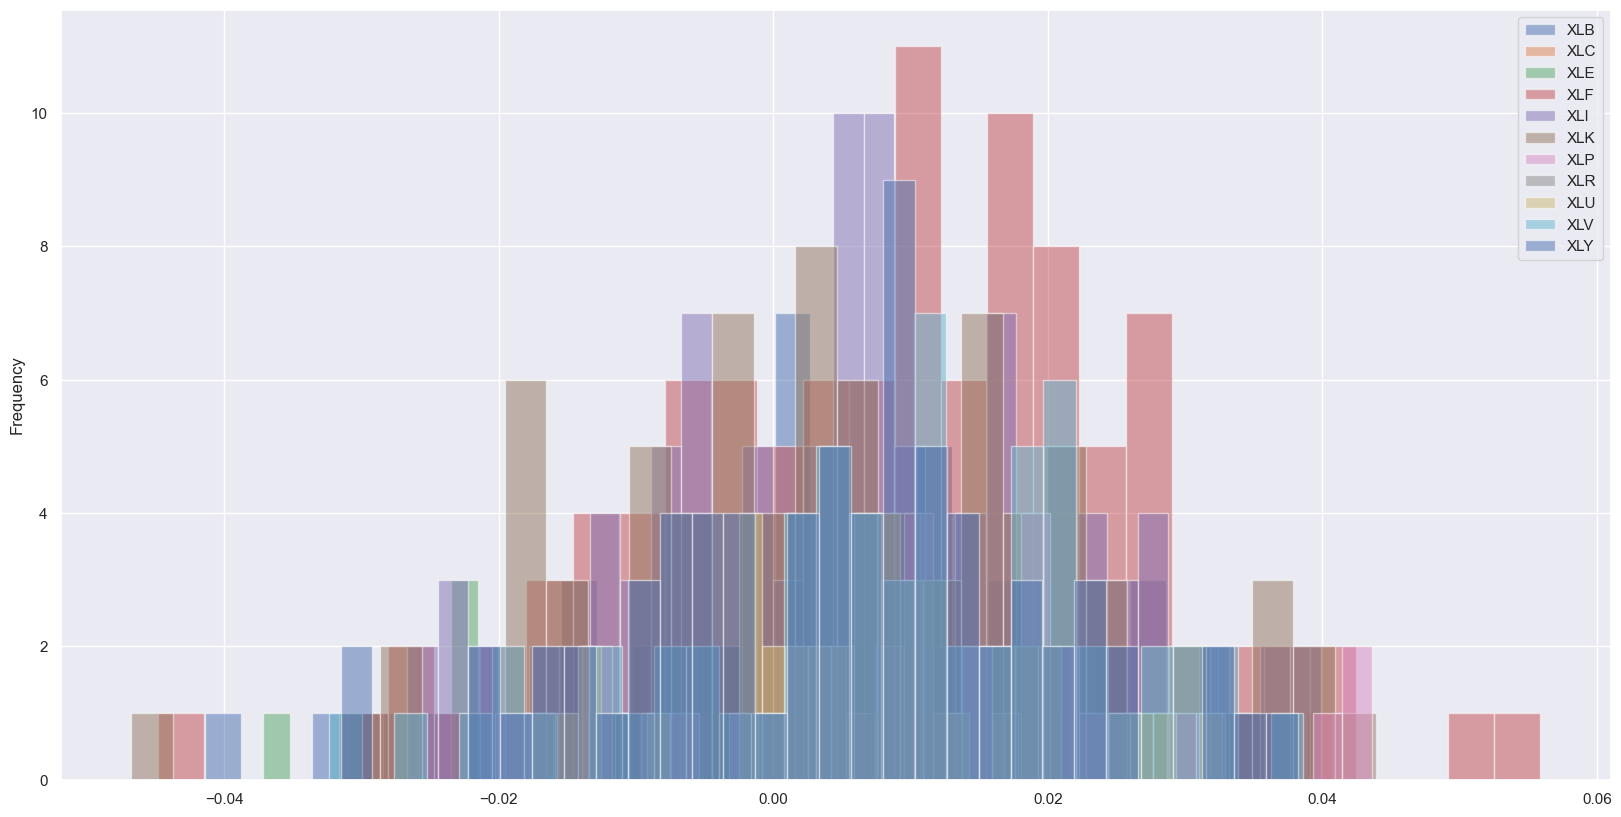

In [416]:
# Plot the distribution of correlation values for each sectors
grouped = df_correlation.groupby(['sector'])
grouped['corr'].plot.hist(alpha=0.5, bins=30)

plt.legend()
plt.show()

In [417]:
# Top correlated stocks from each sector
top_sector_df_correlation = df_correlation.groupby(['sector']).apply(get_max_row)
top_sector_df_correlation

,permno,corr,tic,sector
sector,,,,
XLB,85926,0.036,SEE,XLB
XLC,53065,0.041,IPG,XLC
XLE,87137,0.022,DVN,XLE
XLF,10629,0.056,FNB,XLF
XLI,76573,0.040,MLI,XLI
XLK,88664,0.044,JKHY,XLK
XLP,14816,0.044,TR,XLP
XLR,76123,0.018,JOE,XLR
XLU,21792,0.033,CNP,XLU


In [418]:
# Top correlated stocks regardless sector
top_df_correlation = df_correlation.sort_values(by="corr", ascending=False)[:11]
top_df_correlation

,permno,corr,tic,sector
30216,10629,0.056,FNB,XLF
1340835,76838,0.051,PRA,XLF
1990479,88664,0.044,JKHY,XLK
169965,14816,0.044,TR,XLP
56655,11308,0.042,KO,XLP
1393713,77643,0.042,FCF,XLF
876264,53065,0.041,IPG,XLC
2035803,89290,0.041,SYNA,XLK
253059,18729,0.040,CL,XLP
1303065,76573,0.040,MLI,XLI


# Data Merge with Technical Indicators
## Tech

In [419]:
selected_tech_tic = ["QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "INTU", "WU", "LRCX", "TXN", "CSCO"]
selected_tech_ret = retail_ret[retail_ret['tic'].isin(selected_tech_tic)]

# Check if their lengths are consistent
assert selected_tech_ret.groupby(["permno"]).size().nunique() == 1

# Sort by date 
selected_tech_ret = selected_tech_ret.sort_values(['date','tic'])

## Diversified

In [420]:
selected_sector_tic = top_sector_df_correlation['tic']
selected_sector_ret = retail_ret[retail_ret['tic'].isin(selected_sector_tic)]

# Check if their lengths are consistent
assert selected_sector_ret.groupby(["permno"]).size().nunique() == 1

# Sort by date 
selected_sector_ret = selected_sector_ret.sort_values(['date','tic'])

selected_sector_ret

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20
3587734,CNP,21792,2007-01-03,-0.379,2,XLU,17.050,0.002,-0.015,-0.032,0.026
10198361,DVN,87137,2007-01-03,-0.068,1,XLE,64.860,-0.018,-0.003,0.014,0.082
195763,FNB,10629,2007-01-03,-0.732,3,XLF,18.340,0.007,-0.027,-0.050,-0.029
5008230,IPG,53065,2007-01-03,-0.389,2,XLC,12.240,0.007,0.044,0.119,0.084
10843256,JKHY,88664,2007-01-03,0.216,3,XLK,21.370,0.013,0.011,-0.010,0.002
...,...,...,...,...,...,...,...,...,...,...,...
6374740,MLI,76573,2021-12-31,0.259,3,XLI,59.360,-0.008,0.000,-0.021,-0.130
9593440,SEE,85926,2021-12-31,0.205,2,XLB,67.470,-0.013,-0.026,0.003,0.007
2046799,TR,14816,2021-12-31,-0.274,3,XLP,36.230,0.006,0.004,-0.035,-0.063
6473595,VRTX,76744,2021-12-31,0.164,1,XLV,219.600,0.013,0.010,0.066,0.107


In [421]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

yf_symbol = YahooDownloader(start_date = START_DATE,
                          end_date = DAY_AFTER_END_DATE,
                          ticker_list = selected_sector_tic).fetch_data()

# Stack
processed = fe.preprocess_data(yf_symbol)
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
processed['date'] = pd.to_datetime(processed['date'])
processed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (41547, 8)
Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2007-01-03,16.630,17.250,16.620,8.712,5540800,CNP,2,0.000,8.741,8.698,100.000,66.667,100.000,8.712,8.712,0.000
1,2007-01-03,66.030,66.250,64.240,44.847,6297900,DVN,2,0.000,8.741,8.698,100.000,66.667,100.000,44.847,44.847,0.000
2,2007-01-03,18.250,18.790,18.200,8.567,282800,FNB,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,0.000
3,2007-01-03,12.230,12.350,12.080,8.387,3313000,IPG,2,0.000,8.741,8.698,100.000,66.667,100.000,8.387,8.387,0.000
4,2007-01-03,21.530,21.890,21.160,17.301,565300,JKHY,2,0.000,8.741,8.698,100.000,66.667,100.000,17.301,17.301,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,2021-12-31,59.160,59.590,58.690,58.141,158200,MLI,4,0.805,59.134,54.512,59.498,54.888,23.802,56.878,53.642,2.495
41543,2021-12-31,66.950,67.660,66.820,66.264,510600,SEE,4,1.101,67.080,61.021,59.940,156.421,23.167,63.532,61.330,2.495
41544,2021-12-31,34.188,34.329,33.764,33.733,100573,TR,4,0.761,36.910,31.927,56.292,21.555,3.458,32.928,31.338,2.495
41545,2021-12-31,222.630,223.500,219.040,219.600,1142000,VRTX,4,7.364,228.355,199.916,65.058,90.909,46.178,205.856,195.491,2.495


In [422]:
processed['tic'].unique()

array(['CNP', 'DVN', 'FNB', 'IPG', 'JKHY', 'JOE', 'MLI', 'SEE', 'TR',
       'VRTX', 'WHR'], dtype=object)

In [423]:
# Merge technical indicators with returns
df_merged = pd.merge(retail_ret, processed, on=['tic', 'date'])
df_merged.to_csv('data/merged.csv', index=False)  # set index=False to exclude row index from CSV file